<a href="https://colab.research.google.com/github/llayer/ml_exercise/blob/master/Higgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Higgs ML dataset studies

In [1]:
import pandas as pd
import numpy as np

In [2]:
#!git clone https://github.com/llayer/ml_exercise
#!pip3 install scikit-optimize

fatal: destination path 'ml_exercise' already exists and is not an empty directory.


In [2]:
! ls

ml_exercise  sample_data  xgboost.h5


## 1. Load data

In [3]:
sig = pd.read_hdf('higgs_signal.h5')
bkg = pd.read_hdf('higgs_bkg.h5')

In [4]:
sig.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,...,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,label
0,0.723801,-0.914611,0.910944,1.194830,-0.448292,0.839489,-0.871428,0.587799,0.000000,0.654446,...,-0.916982,3.101961,0.867059,1.127180,1.211664,0.695883,0.694068,0.755813,0.761658,0
1,1.974119,0.660297,-1.362428,1.234102,1.677716,1.478815,0.408940,-0.105273,0.000000,1.017048,...,1.604089,3.101961,1.938668,1.233898,0.990063,0.524871,0.900614,0.917613,1.083369,0
2,0.946889,0.169416,1.210014,0.343294,-1.579545,0.999435,1.030804,-0.475041,0.000000,0.435374,...,0.558635,3.101961,0.881641,0.845381,0.997408,0.695120,0.787132,0.657668,0.721147,0
3,1.298084,-0.897079,1.224441,0.618091,0.856746,0.493122,-0.021810,-1.520042,2.173076,0.973234,...,0.581386,0.000000,0.848238,0.925814,0.973957,0.961469,0.946147,1.028120,0.848133,0
4,1.022289,-0.481195,0.169649,1.103255,0.744424,1.648197,-0.780327,-1.484007,2.173076,0.675472,...,-0.284934,1.550981,0.717778,0.752909,0.996800,1.648921,1.138676,1.118826,0.977200,0


In [5]:
data = pd.concat([sig, bkg])

### Split data in train and validation set

In [73]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def prep_data(data, val_size = 0.3):


    X_train, X_val = train_test_split(data, test_size = val_size, stratify = data['label'], random_state = 0)

    return X_train, X_val

X_train, X_val = prep_data(data)

In [74]:
print( len(data) )
print( len(X_train) )
print( len(X_val) )

20000
14000
6000


## 2. Feature importance with XGBoost

In [75]:
import xgboost as xgb
from xgboost import plot_importance

def get_feature_importance(data):

    features = data.drop(['label'], axis=1).values
    labels = data[['label']].values.ravel()
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

    # Early stopping
    early_stopping_rounds = 5

    # Define model
    model_bdt = xgb.XGBClassifier(n_jobs = 4)

    # Last in list is used for early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]

    # Fit with early stopping
    model_bdt.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, 
                early_stopping_rounds=early_stopping_rounds, verbose=False)
    
    plot_importance(model_bdt)
    fscore = list(model_bdt.feature_importances_)
    feature_importance = pd.DataFrame(list(data.drop(['label'], axis=1)))
    feature_importance['f-score'] = fscore
    feature_importance.columns = ['feature', 'fscore']
    feature_importance = feature_importance.sort_values(by=['fscore'], ascending=False)

    return feature_importance


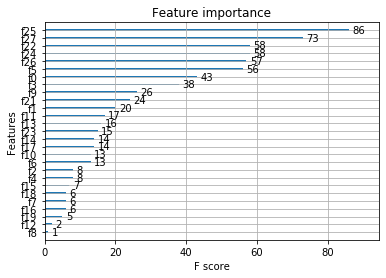

In [76]:
feature_importance = get_feature_importance(X_train)

In [77]:
feature_importance.head()

,feature,fscore
25,m_bb,0.148234
26,m_wbb,0.080355
27,m_wwbb,0.074038
22,m_jjj,0.069354
5,jet1_pt,0.061405


## Test algorithms

### Set up Bayesian optimization

In [124]:
import xgboost as xgb
import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


def fit_rf(X_train, y_train, X_test, y_test, p):
    
    clf = rfc = RandomForestClassifier(n_estimators=p['n_estimators'], max_depth = p['max_depth'],  
              min_samples_split = p['min_samples_split'], min_samples_leaf = p['min_samples_leaf'],
                                       random_state=42, n_jobs=4).fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)[:,1]
    return y_test, predictions    
    
    

def fit_lreg(X_train, y_train, X_test, y_test, p):

    clf = LogisticRegression(random_state=0, C = p['C']).fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)[:,1]
    return y_test, predictions


def fit_xgboost(X_train, y_train, X_test, y_test, p):

    # Early stopping
    early_stopping_rounds = 10
    # Define model
    model_bdt = xgb.XGBClassifier(n_jobs = 4, n_estimators = int(p['n_estimators']), learning_rate = p['learning_rate'],
                            max_depth = int(p['max_depth']), min_child_weight = int(p['min_child_weight']))
    # Last in list is used for early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]
    # Fit with early stopping
    #model_bdt.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, 
    #                early_stopping_rounds=early_stopping_rounds, verbose=False)
    model_bdt.fit(X_train, y_train, eval_metric=["logloss"])
    predictions = model_bdt.predict_proba(X_test)[:,1]
    return y_test, predictions

def fit_keras(X_train, y_train, X_test, y_test, p):

    # Early stopping
    patience = 5
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
    
    # Define model
    model = create_model(X_train.shape[1], p['dense_layers'], p['dense_units'], 0., 
                            #p['regulizer_value'], 
                            p['dropout_value'], 
                            p['learning_rate'])
    
    #history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 100,# p['batch_size'], 
    #                    epochs=1000, verbose=0, callbacks=[es])

    history = model.fit(X_train, y_train, batch_size = p['batch_size'], epochs=p['epochs'], verbose=0)

    predictions = model.predict(X_test)
    return y_test, predictions


def optimize( algo, dimensions, initial_param, data, cv = False, kfold_splits = 5, num_calls=12, random_state = 42): 

    prior_values = []
    prior_names = []
    for var in dimensions:
        name = var.name
        print( name )
        prior_names.append(name)
        prior_values.append(initial_param[name])

    global num_skopt_call
    num_skopt_call = 0
    #errors = []
    
    cv_results = []

    @use_named_args(dimensions)
    def fitness(**p): 

        global num_skopt_call

        print('\n \t ::: {} SKOPT CALL ::: \n'.format(num_skopt_call+1))
        print(p)

        reduced_feat = feature_importance.iloc[0:p['n_feat']]
        reduced_feat = list(reduced_feat['feature'])
        data_red = data[reduced_feat]
        features = data_red.values
        labels = data[['label']].values.ravel()

        if cv == False:
            X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=random_state)
            if algo == 'xgboost':
                y_test, y_pred = fit_xgboost(X_train, y_train, X_test, y_test, p)
            if algo == 'keras':
                y_test, y_pred = fit_keras(X_train, y_train, X_test, y_test, p)
            if algo == 'lreg':
                y_test, y_pred = fit_lreg(X_train, y_train, X_test, y_test, p)
            if algo == 'rf':
                y_test, y_pred = fit_rf(X_train, y_train, X_test, y_test, p)
            score = roc_auc_score(y_test, y_pred )
            print(score)

        else:
            cv_scores = []    
            enum = enumerate(KFold(n_splits=kfold_splits, shuffle=True, random_state=random_state).split(features,labels))
            for i,(index_train, index_valid) in enum:
                X_train, X_test = features[ index_train ], features[ index_valid ]
                y_train, y_test = labels[ index_train ], labels[ index_valid ]   
                if algo == 'xgboost':
                    y_test, y_pred  = fit_xgboost(X_train, y_train, X_test, y_test, p)
                if algo == 'keras':
                    y_test, y_pred  = fit_keras(X_train, y_train, X_test, y_test, p)
                if algo == 'lreg':
                    y_test, y_pred = fit_lreg(X_train, y_train, X_test, y_test, p)
                if algo == 'rf':
                    y_test, y_pred = fit_rf(X_train, y_train, X_test, y_test, p)
                score = roc_auc_score(y_test, y_pred )
                print(score)
                cv_scores.append(score)
                #print( cv_scores )
            score = np.mean(cv_scores)
            std = np.std(cv_scores)
            cv_results.append((num_skopt_call, std))
            print(score)
            print(std)

        num_skopt_call += 1

        return -1*score

    search_result = gp_minimize( func = fitness, dimensions = dimensions,
                                 acq_func = 'EI', # Expected Improvement
                                 n_calls = num_calls, x0 = prior_values )

    params = pd.DataFrame(search_result['x_iters'])
    params.columns = [*prior_names]
    params = params.rename_axis('call').reset_index()
    scores = pd.DataFrame(search_result['func_vals'])
    scores.columns = ['score']
    result = pd.concat([params, scores], axis=1)
    result = result.sort_values(by=['score'])
    #errors_frame = pd.DataFrame(errors, columns = ['call', 'q_error', 't_error'])
    #result = pd.merge(result, errors_frame, on=['call']) 
    
    if cv_results is not None:
        cv_frame = pd.DataFrame(cv_results, columns = ['call', 'std'])
        result = pd.merge(result, cv_frame, on=['call'])
    
    return result

### 1. XGBoost

In [112]:
from skopt.space import Real, Categorical, Integer

# Skopt dimensions
skopt_dims = [       
    Integer(        low=100,    high=1000,                         name='n_estimators'     ),
    Real(        low=1e-2, high=1,     prior='log-uniform', name='learning_rate'     ),
    Integer(        low=2,    high=25,                         name='max_depth'     ),
    Integer(        low=1,    high=25,                         name='min_child_weight'     ),
    Real(        low=1e-6, high=1e-2,     prior='log-uniform', name='reg_alpha'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )

]

# Initial parameters
init_param = {'n_estimators' : 100, 'learning_rate' : 0.3, 'reg_alpha' : 1e-5, 'max_depth' : 6, 'min_child_weight' : 1, 'n_feat':12 }

In [114]:
search_result = optimize('xgboost', skopt_dims, init_param, X_train, cv = True, num_calls=50, random_state = 42)

n_estimators
learning_rate
max_depth
min_child_weight
reg_alpha
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1e-05, 'n_feat': 12}
0.7783481905974743
0.756554135135797
0.7831935302821571
0.7820349578088368
0.766658876263219
0.7733579380174967
0.010238919749100243

 	 ::: 2 SKOPT CALL ::: 

{'n_estimators': 871, 'learning_rate': 0.5524950139780906, 'max_depth': 22, 'min_child_weight': 24, 'reg_alpha': 8.638251346421589e-05, 'n_feat': 21}
0.7504984734569262
0.7475994701997568
0.761080157150875
0.7572154853413278
0.75337938516367
0.7539545942625112
0.0047764065046249846

 	 ::: 3 SKOPT CALL ::: 

{'n_estimators': 620, 'learning_rate': 0.1943929417079289, 'max_depth': 8, 'min_child_weight': 14, 'reg_alpha': 0.0002506676081734915, 'n_feat': 19}
0.7688644397097119
0.7676945322002628
0.7822195009949486
0.7740853135542686
0.7656980031392944
0.7717123579196972
0.005940656514469035

 	 ::: 4 SKOPT CALL ::: 

{'n_

0.784343137495
0.7785782945166899
0.7991912852696565
0.7980884299005873
0.7883257232317996
0.7897053740827465
0.007933814382172288

 	 ::: 29 SKOPT CALL ::: 

{'n_estimators': 502, 'learning_rate': 0.036813463532164116, 'max_depth': 2, 'min_child_weight': 1, 'reg_alpha': 0.01, 'n_feat': 20}
0.779763508273537
0.769836386419481
0.7792943517526405
0.7825046561399782
0.7726907407142815
0.7768179286599837
0.004752338212299759

 	 ::: 30 SKOPT CALL ::: 

{'n_estimators': 480, 'learning_rate': 0.06026834213066721, 'max_depth': 25, 'min_child_weight': 25, 'reg_alpha': 0.01, 'n_feat': 27}
0.779114268279741
0.7771333847623245
0.7887463646104393
0.789619564773442
0.7815633808854117
0.7832353926622717
0.005062455043312501

 	 ::: 31 SKOPT CALL ::: 

{'n_estimators': 798, 'learning_rate': 0.020792518125877926, 'max_depth': 25, 'min_child_weight': 25, 'reg_alpha': 1e-06, 'n_feat': 18}
0.7844895672617735
0.7806752504102075
0.7961416398795857
0.7995245836022185
0.7893932466387301
0.7900448575585031
0.

In [115]:
search_result

,call,n_estimators,learning_rate,max_depth,min_child_weight,reg_alpha,n_feat,score
39,39,250,0.034592,22,24,0.000001,18,-0.794078
21,21,1000,0.010000,19,25,0.000001,14,-0.793370
35,35,655,0.012708,21,25,0.000002,19,-0.793320
47,47,218,0.024906,25,25,0.000009,22,-0.792947
36,36,1000,0.010000,25,13,0.000227,19,-0.792553
16,16,103,0.063965,25,20,0.000015,21,-0.791930
37,37,227,0.015861,23,25,0.000001,17,-0.791831
15,15,100,0.087615,25,23,0.010000,17,-0.790605
19,19,1000,0.010000,18,24,0.000001,25,-0.790139
30,30,798,0.020793,25,25,0.000001,18,-0.790045


In [0]:
#search_result.to_hdf('xgboost.h5', 'frame')

### 2. Keras

In [127]:
import keras
from keras.layers import Input, Flatten, Dense, Dropout, Reshape

def create_model( n_features, dense_layers, dense_units, regulizer_value, dropout_value, learning_rate ):

    m_input = Input(shape = (n_features, ))
    m = m_input
    
    for _ in range(dense_layers):
        m = Dense( units=dense_units, activation='relu', 
                   kernel_initializer='lecun_normal',
                   kernel_regularizer=keras.regularizers.l2(regulizer_value) )(m)
        m = Dropout(dropout_value)(m)

    m_output = Dense( units=1, activation='sigmoid', 
                      kernel_initializer='lecun_normal',
                      kernel_regularizer=keras.regularizers.l2(regulizer_value) )(m)

    model = keras.models.Model(inputs=m_input, outputs=m_output)
    model.compile( loss = 'binary_crossentropy',
                        optimizer = keras.optimizers.Adam(lr=learning_rate) )
    return model

In [128]:
dimensions = [
    Integer(        low=20,    high=200,                         name='epochs'     ),
    Integer(     low=1,    high=5,                        name='dense_layers'      ),
    Integer(     low=100,    high=1000,                    name='batch_size'      ),
    Integer(     low=5,    high=200,                        name='dense_units'       ),
    #Real(        low=1e-3, high=0.9,  prior="log-uniform", name='regulizer_value'   ),
    Real(        low=1e-3, high=0.5,   prior="log-uniform",                    name='dropout_value'     ),
    Real(        low=1e-4, high=1e-1, prior='log-uniform', name='learning_rate'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )

]


# Initial parameters
init_param = {'epochs' : 50 ,'learning_rate' : 1e-2, 'dense_layers' : 3, 'regulizer_value' : 1e-2, 'dropout_value': 0.02, 
             'dense_units' : 20, 'batch_size' : 100, 'n_feat': 20}

In [129]:
search_result_k = optimize('keras', dimensions, init_param, X_train, cv = True, num_calls=12, random_state = 42)

W0227 22:26:58.030966 139739968608064 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0227 22:26:58.075168 139739968608064 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0227 22:26:58.083770 139739968608064 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0227 22:26:58.119535 139739968608064 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_9

epochs
dense_layers
batch_size
dense_units
dropout_value
learning_rate
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'epochs': 50, 'dense_layers': 3, 'batch_size': 100, 'dense_units': 20, 'dropout_value': 0.02, 'learning_rate': 0.01, 'n_feat': 20}


W0227 22:26:58.321961 139739968608064 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0227 22:26:58.332959 139739968608064 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0227 22:26:58.341514 139739968608064 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0.727082465979314


KeyboardInterrupt: 

## 3. LReg

In [125]:
dimensions = [
    Real(        low=1e-3, high=100,   prior="log-uniform",                    name='C'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )
]

# Initial parameters
init_param = {'C' : 0.1, 'n_feat': 20}

In [126]:
search_result_k = optimize('lreg', dimensions, init_param, X_train, cv = True, num_calls=12, random_state = 42)

C
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'C': 0.1, 'n_feat': 20}


UnboundLocalError: local variable 'y_pred' referenced before assignment

In [96]:
search_result_k.head()

,call,C,n_feat,score
46,46,98.971806,19,-0.685734
48,48,13.799586,19,-0.685698
9,9,16.849722,24,-0.685674
34,34,97.217833,27,-0.685657
44,44,99.704363,27,-0.685657


## 4. Random Forest

In [110]:
dimensions = [
    Integer(     low=100,    high=1000,                        name='n_estimators'       ),
    Integer(     low=5,    high=30,                        name='max_depth'       ),
    Integer(     low=2,    high=100,                        name='min_samples_split'       ),
    Integer(     low=1,    high=10,                        name='min_samples_leaf'       ),
    Integer(     low=5,    high=27,                        name='n_feat'       )
]

# Initial parameters
init_param = {'n_estimators': 200, 'max_depth': 10, 'min_samples_split' : 20, 'min_samples_leaf' : 4, 'n_feat': 20}

In [111]:
search_result_k = optimize('rf', dimensions, init_param, X_train, cv = True, num_calls=50, random_state = 42)

n_estimators
max_depth
min_samples_split
min_samples_leaf
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 4, 'n_feat': 20}
0.7790976865117267
0.775976742667287
0.7933420072452676
0.7910026221419877
0.7812485329207481
0.7841335182974035
0.00681463993777847

 	 ::: 2 SKOPT CALL ::: 

{'n_estimators': 572, 'max_depth': 13, 'min_samples_split': 87, 'min_samples_leaf': 6, 'n_feat': 18}
0.7804114727467162
0.7756298010596006
0.7950635236491657
0.7942231189602921
0.7818266897180963
0.7854309212267742
0.0078017571707483906

 	 ::: 3 SKOPT CALL ::: 

{'n_estimators': 788, 'max_depth': 17, 'min_samples_split': 97, 'min_samples_leaf': 3, 'n_feat': 22}
0.7796349357953943
0.7739690732169243
0.7924388999438747
0.7922636600527695
0.7809836932227573
0.7838580524463441
0.007323574924894503

 	 ::: 4 SKOPT CALL ::: 

{'n_estimators': 181, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 5, 'n_feat': 5}
0.7539551343276272
0.


 	 ::: 32 SKOPT CALL ::: 

{'n_estimators': 879, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 3, 'n_feat': 14}
0.7892651164499301
0.7851217152793084
0.8010092351650594
0.799821718850832
0.7937995872787134
0.7938034746047686
0.006068144755946828

 	 ::: 33 SKOPT CALL ::: 

{'n_estimators': 173, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 3, 'n_feat': 18}
0.7834334361913157
0.7829734834570079
0.799687228940252
0.7978487305892058
0.7923085244703717
0.7912502807296307
0.0070064248672362444

 	 ::: 34 SKOPT CALL ::: 

{'n_estimators': 997, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 9, 'n_feat': 13}
0.7880263308271904
0.7833104760038858
0.799495892647584
0.7978934029848308
0.7910771984756664
0.7919606601878316
0.006050823148116353

 	 ::: 35 SKOPT CALL ::: 

{'n_estimators': 272, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'n_feat': 11}
0.7900590004816366
0.7809329055747394
0.7980248992295526
0.7971694549048759
0.7905536

## Evaluate on validation set

In [120]:
best_xgboost = search_result.iloc[0].to_dict()

In [121]:
best_xgboost

{'call': 39.0,
 'n_estimators': 250.0,
 'learning_rate': 0.034591731302067344,
 'max_depth': 22.0,
 'min_child_weight': 24.0,
 'reg_alpha': 1.356787126198538e-06,
 'n_feat': 18.0,
 'score': -0.7940784631890276}

In [122]:
def evaluate(X_train, X_val, feature_importance, algo, p):
    
    reduced_feat = feature_importance.iloc[0:int(p['n_feat'])]
    reduced_feat = list(reduced_feat['feature'])
    y_train = X_train[['label']].values.ravel()
    X_train = X_train[reduced_feat].values
    y_val = X_val[['label']].values.ravel()
    X_val = X_val[reduced_feat].values
    
    print(len(X_train), len(X_val))
    
    y_val, y_pred = fit_xgboost(X_train, y_train, X_val, y_val, p)
    return roc_auc_score(y_val, y_pred)
    

In [123]:
evaluate(X_train, X_val, feature_importance, 'xgboost', best_xgboost)

14000 6000


0.8000579999999999